# Fuzzy Logic for Python 3

In my ventures into game dev, scheduling etc. I often came across the need to normalize values and apply some logic on these values. I thought that fuzzy logic would be the best tool for this job, but the libraries I found were not easily integrated into the rest of my code and not very intuitive to use.
One of my (many) approaches was to actually build fuzzy values out of native python bools or floats, but this was not supported by the language itself due to restrictions on what can be done with bool. Then I started to collect useful math functions from different places and made them usable just by pluggin them in.

The doctests in the modules should give a good idea how to use things by themselves, while here are some examples how to use everything together.

## Usage

1. Define a Domain and specify the measurable range & resolution.
2. Define some fuzzysets ("adjectives") as attributes that describe ranges within
the domain using Set(). Each set is defined by its membership function func(REAL) -> [0,1]
3. You can combine fuzzysets of the same domain using fuzzy logic operators (~, &, |, +, *) to
define derived fuzzysets.
4. Now suppose you have a value x. Call the fuzzyset(x) directly to produce a
membership value or call the domain with it to get a dictionary of memberships.
5. To really put these to work, you will want to map membership values of one or
more domains onto another domain, producing "real world" values again that can
be used to control things. This is called inference (combining domains) and
defuzzification (turning membership values back into measurables).

In [ ]:
%matplotlib inline

from fuzzy.classes import Domain, Set
from fuzzy.functions import alpha, triangular
from fuzzy.hedges import plus, minus, very

numbers = Domain("numbers", low=0, high=20, res=0.1)
numbers.close_to_10 = Set(numbers, alpha(0.2, 0.8, 
                            triangular(0, 20)
                            ))
numbers.close_to_5 = Set(numbers, triangular(1,10))

foo = minus(numbers.close_to_5)
bar = very(numbers.close_to_10)
bar.plot()
foo.plot()
baz = foo + bar
baz.plot()

numbers(11)


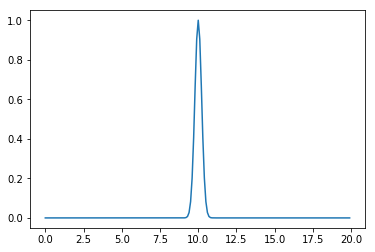

In [11]:
%matplotlib inline

from fuzzy.classes import Domain, Set
from fuzzy.functions import alpha, triangular, gauss
from fuzzy.hedges import plus, minus, very

numbers = Domain("numbers", low=0, high=20, res=0.1)
numbers.close_to_10 = Set(numbers, gauss(10, 10))

numbers.close_to_10.plot()

## Rules
Rules aka *Fuzzy Inference* is done when domains and sets are defined to combine sets of different domains. For this to work, first we need to make sure we only get a single membership value if we query a domain with multiple sets. 

In [ ]:
from numpy import outer

from fuzzy.classes import Domain, Set, Rule
from fuzzy.functions import triangular

form = Domain("form", 1, 4.1, res=1)
medium_form = Set(form, triangular(1, 4, p=3))
medium_form.plot()

diff = Domain("difficulty", 1, 5.1, res=1)
medium_difficulty = Set(diff, triangular(1,5, p=3))
medium_difficulty.plot()

# this should be 
# max(min(m_a(x), m_b(x)), 1-m_a(x)) for every elem
outer([0, 0.6, 1, 0.2], [0, 0.4, 1, 0.8, 0.3, 0])


fromiter

## Sources
* Fuzzy Logic and Control: Software and Hardware Applications, Volume 2

      By: Mohammad Jamshidi; Nader Vadiee; Timothy J. Ross - University of New Mexico
      Publisher: Prentice Hall
      Pub. Date: June 07, 1993